# Calculating the coefficient of variation of the cumulative plots of radial analysis

In [1]:
import sys
sys.path.append('../')

import calculate_radial_analysis as calculate
import tools
import render

import json
import glob
import os
import re
import numpy as np
import math
from natsort import natsorted
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# Automatically read parameters from input directory

In [6]:
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
analysis_info = single_cell_heatmap_location.split('individual_spatiotemporal_heatmaps/')[1]
radius, t_range, num_bins = list(map(int,analysis_info.split('/')[0].split('.') ))
focal_cell, focal_event , subject_cell, subject_event = analysis_info.split('/')[1].split('_')
save_parent_dir = os.path.join('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/statistics')

## Compile individual heatmaps into cumulative plots 

Compile cumulative heatmap by iteratively adding single-apoptosis heatmaps from previous output or different pre-established output 

In [7]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N+=1
P_events = N_events/N_cells
N

1839

In [8]:
print("The number of {} cells counted is equal to = ".format(subject_cell), N_cells.sum())

The number of wt cells counted is equal to =  32587746.0


Function to plot heatmaps: 

`render.auto_plot_cumulative(input_2d_hist, input_type, num_bins, radius, t_range, title, expt_label, cb_label, save_path, SI = True)`

Where the variables needed are as follows:

- `input_2d_hist` = Input 2D histogram
- `input_type` = String version of input variable name
- `num_bins` = Number of bins the histogram is sorted into
- `radius` = Spatial extent of scan
- `t_range` = Temporal range of scan
- `focal_cell` = Cell type that is the focal point of the scan 
- `focal_event` = Event type that is the focal point of the scan 
- `subject_cell` = Cell type that is scanned over
- `subject_event` = Event type that is the scanned over 
- `save_parent_dir` = Root directory into which different plots will be saved according to scan parameters, if empty then plots not saved out 
- `cbar_lim` = Tuple that is the limits of the colorbar, if left blank then will be automatically decided
- `include_apop_bin` = Boolean option to include the first spatial bin (which for 40px/13um bins usually only includes the site of apoptosis)
- `SI` = If True then plots the xy in SI base unit instead of pixel/frames

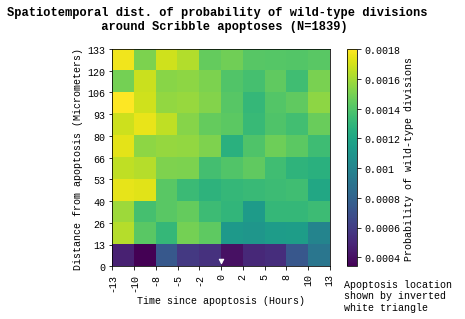

In [9]:
render.auto_plot_cumulative(P_events,
                     'P_events',
                      N,
                      num_bins  ,
                      radius ,
                      t_range , 
                      focal_cell, 
                      focal_event, 
                      subject_cell, 
                      subject_event, 
                      '',#save_parent_dir ,
                      '',
                      include_apop_bin = True,
                      SI = True)

# means

In [10]:
def plot_labels(SI):
    xlocs, xlabels, ylocs, ylabels = render.kymo_labels(num_bins, 1, radius, t_range, SI)
    plt.xticks(xlocs, xlabels, rotation = 'vertical')
    plt.yticks(ylocs, ylabels)
    if SI == True:
            time_unit = '(Hours)'
            distance_unit = '(Micrometers)'
    else:
            time_unit = '(Frames)'
            distance_unit = '(Pixels)'
    
    plt.xlabel("Time since apoptosis "+ time_unit)
    plt.ylabel("Distance from apoptosis "+ distance_unit)
    plt.scatter(num_bins/2-0.5, num_bins-0.75, s=20, c='white', marker='v')
    plt.text(num_bins+0.15, num_bins+1.5, 'Apoptosis location \nshown by inverted \nwhite triangle')

In [20]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N += 1
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))

mean_N_cells = N_cells / N
mean_N_events = N_events / N

P_events = N_events / N_cells
mean_P_events = P_events / N

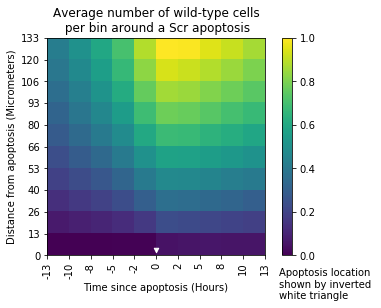

In [13]:
plt.imshow(np.flipud(mean_N_cells))
plt.title('Average number of wild-type cells\n per bin around a Scr apoptosis')
plot_labels(SI=True)
plt.colorbar()

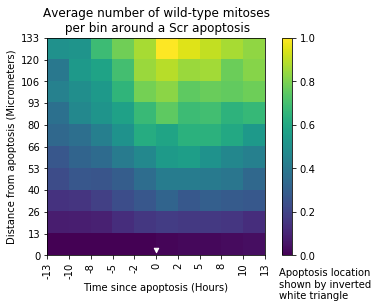

In [14]:
plt.imshow(np.flipud(mean_N_events))
plt.title('Average number of wild-type mitoses\n per bin around a Scr apoptosis')
plot_labels(SI=True)
plt.colorbar()

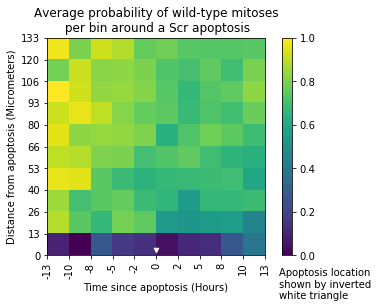

In [15]:
plt.imshow(np.flipud(mean_P_events))
plt.title('Average probability of wild-type mitoses\n per bin around a Scr apoptosis')
plot_labels(SI=True)
plt.colorbar()

# coeff var for N_cells

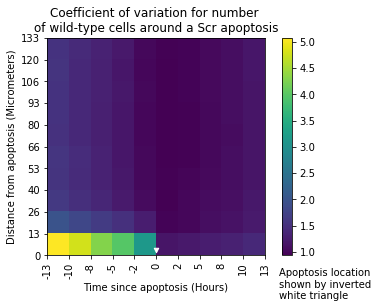

In [16]:
N_cells, sum_dev_sq = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells = np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        dev = N_cells - mean_N_cells
        dev_sq = dev**2
        sum_dev_sq += dev_sq
        N+=1

### calculating the variance
var = sum_dev_sq / N
# plt.imshow(np.flipud(var))
# plt.colorbar()
### calculating the standard dev
st_dev = np.sqrt(sum_dev_sq / N)
# plt.imshow(np.flipud(st_dev))
# plt.colorbar()
### coeff of var
coeff_var = st_dev / mean_N_cells
plt.imshow(np.flipud(coeff_var))
plt.title('Coefficient of variation for number \nof wild-type cells around a Scr apoptosis')
plt.colorbar()
plot_labels(SI=True)
#plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coefficient of variation for number of wild-type cells around a Scr apoptosis.pdf', bbox_to_inches = 'tight')

# coeff var for N_events

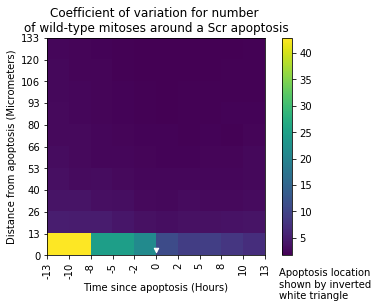

In [17]:
N_events, sum_dev_sq = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_events' in heatmap_ID:
        N_events = np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        dev = N_events - mean_N_events
        dev_sq = dev**2
        sum_dev_sq += dev_sq
        N+=1

### calculating the variance
var = sum_dev_sq / N
# plt.imshow(np.flipud(var))
# plt.colorbar()
### calculating the standard dev
st_dev = np.sqrt(sum_dev_sq / N)
# plt.imshow(np.flipud(st_dev))
# plt.colorbar()
### coeff of var
coeff_var = st_dev / mean_N_events
plt.imshow(np.flipud(coeff_var))
plt.title('Coefficient of variation for number \nof wild-type mitoses around a Scr apoptosis')
plt.colorbar()
plot_labels(SI=True)
#plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coefficient of variation for number of wild-type mitoses around a Scr apoptosis.pdf', bbox_to_inches = 'tight')

# coeff var for P_events

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


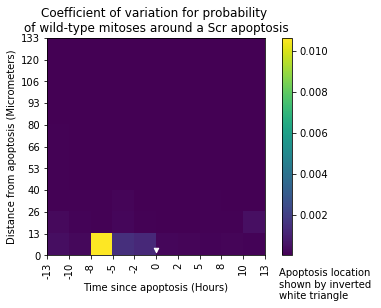

In [18]:
N_cells, sum_dev_sq = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells = np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        heatmap_ID = heatmap_ID.split('N_')[0] + 'N_events.npy'
        N_events = np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        P_events = np.nan_to_num(N_events/N_cells)
        
        dev = P_events - mean_P_events
        dev_sq = dev**2
        sum_dev_sq += dev_sq
        N+=1
### calculating the variance
var = sum_dev_sq / N
# plt.imshow(np.flipud(var))
# plt.colorbar()
### calculating the standard dev
st_dev = np.sqrt(sum_dev_sq / N)
# plt.imshow(np.flipud(st_dev))
# plt.colorbar()
### coeff of var
coeff_var = st_dev / mean_N_cells
plt.imshow(np.flipud(coeff_var))
plt.title('Coefficient of variation for probability \nof wild-type mitoses around a Scr apoptosis')
plt.colorbar()
plot_labels(SI=True)
#plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coefficient of variation for probability of wild-type cells around a Scr apoptosis.pdf', bbox_to_inches = 'tight')

# Different definition of coeff var, not sure if correct

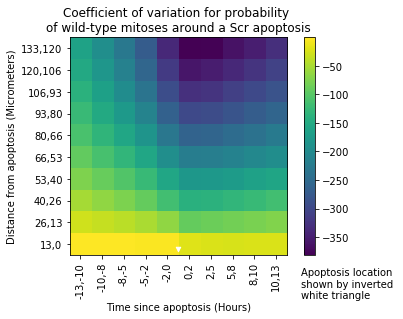

In [131]:
coeff_var = 1-st_dev / st_dev*mean_N_cells
plt.imshow(np.flipud(coeff_var))
plt.title('Coefficient of variation for probability \nof wild-type mitoses around a Scr apoptosis')
plt.colorbar()
plot_labels(SI=True)
#plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coefficient of variation for probability of wild-type cells around a Scr apoptosis.pdf', bbox_to_inches = 'tight')

# Statistics of rare events

Generally, to compare probability estimators, we determine if their values differ by more than their
absolute precision. This absolute precision is often estimated by the standard error

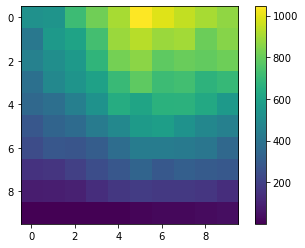

In [21]:
plt.imshow(np.flipud(N_events))
plt.colorbar()

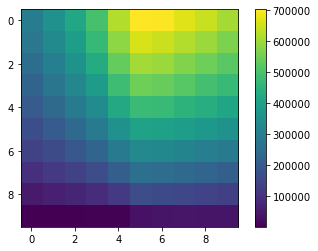

In [22]:
plt.imshow(np.flipud(N_cells))
plt.colorbar()

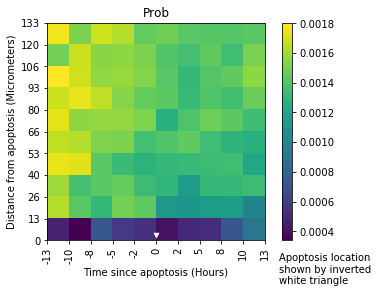

In [23]:
plt.imshow(np.flipud(P_events))
plt.title('Prob')
plt.colorbar()
plot_labels(SI=True)


# reload N_cells, N_events, P_events

In [51]:
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N+=1
P_events = N_events/N_cells
N

1839

In [52]:
p = P_events ## probability of event
n = N_events ## number of events
N = N_cells ## number of observations

#p = n/N 
SE = np.sqrt((p*(1-p))/N)

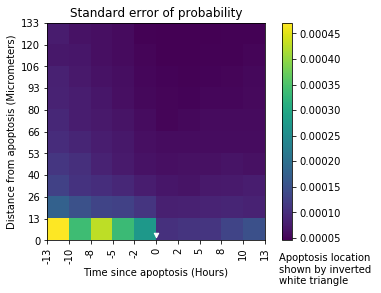

In [25]:
plt.imshow(np.flipud(SE))
plt.colorbar()
plt.title('Standard error of probability')
plot_labels(SI = True)

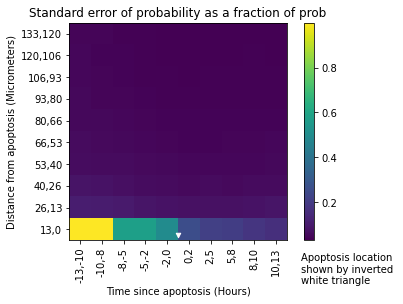

In [46]:
plt.imshow(np.flipud(SE/P_events))
plt.colorbar()
#plt.clim(0,0.25)
plt.title('Standard error of probability as a fraction of prob')
plot_labels(SI = True)

# True coeff of var

In [53]:
cv = np.sqrt(((1-p)/(p*N)))
scr_apop_wt_div_CV = cv

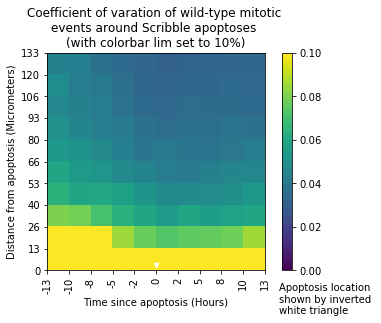

In [34]:
plt.imshow(np.flipud(cv))
plt.colorbar()
plt.clim(0,0.1)
plt.title('Coefficient of varation of wild-type mitotic \nevents around Scribble apoptoses \n(with colorbar lim set to 10%)')
plot_labels(SI=True)
plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_var_cbarlim_0.1_scr_apop_wt_div.pdf', dpi = 300, bbox_inches = 'tight')

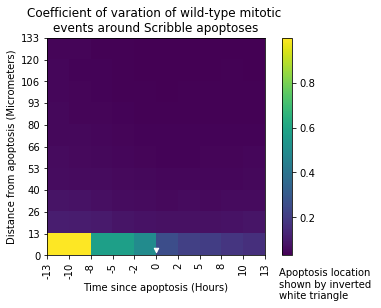

In [35]:
plt.imshow(np.flipud(cv))
plt.colorbar()
#plt.clim(0,0.1)
plt.title('Coefficient of varation of wild-type mitotic \nevents around Scribble apoptoses')
plot_labels(SI=True)
plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_var_scr_apop_wt_div.pdf', dpi = 300, bbox_inches = 'tight')

# reload N_cells, N_events, P_events for different measure

In [55]:
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/wt_control_wt_div'
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N+=1
P_events = N_events/N_cells
N

2453

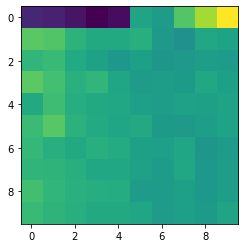

In [40]:
plt.imshow(P_events)

In [56]:
p = P_events ## probability of event
n = N_events ## number of events
N = N_cells ## number of observations

#p = n/N 
SE = np.sqrt((p*(1-p))/N)

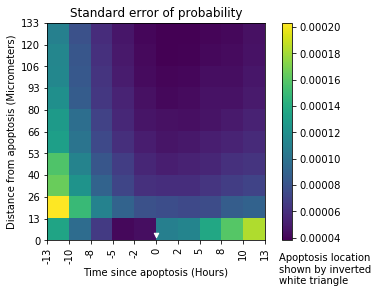

In [42]:
plt.imshow(np.flipud(SE))
plt.colorbar()
plt.title('Standard error of probability')
plot_labels(SI = True)

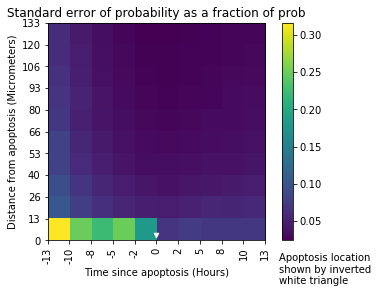

In [43]:
plt.imshow(np.flipud(SE/P_events))
plt.colorbar()
#plt.clim(0,0.25)
plt.title('Standard error of probability as a fraction of prob')
plot_labels(SI = True)

# True coeff of var

In [57]:
cv = np.sqrt(((1-p)/(p*N)))
wt_control_wt_div_CV = cv

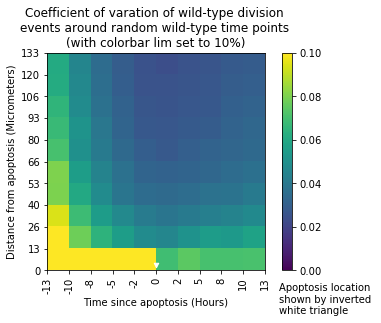

In [45]:
plt.imshow(np.flipud(cv))
plt.colorbar()
plt.clim(0,0.1)
plt.title('Coefficient of varation of wild-type division \nevents around random wild-type time points \n(with colorbar lim set to 10%)')
plot_labels(SI=True)
plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_var_cbarlim_0.1_wt_control_wt_div.pdf', dpi = 300, bbox_inches = 'tight')

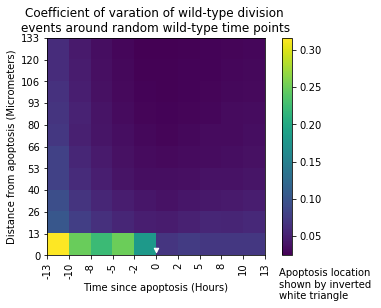

In [46]:
plt.imshow(np.flipud(cv))
plt.colorbar()
#plt.clim(0,0.1)
plt.title('Coefficient of varation of wild-type division \nevents around random wild-type time points')
plot_labels(SI=True)
plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_var_wt_control_wt_div.pdf', dpi = 300, bbox_inches = 'tight')

# comparison of coeff of vars

In [48]:
wt_control_wt_div_CV = cv

In [47]:
scr_apop_wt_div_CV

array([[0.99976457, 0.99983044, 0.57713565, 0.57718218, 0.49986357,
        0.25814674, 0.2131464 , 0.20845904, 0.1795393 , 0.16214712],
       [0.1083761 , 0.105334  , 0.10094876, 0.08537184, 0.0766413 ,
        0.07289133, 0.07533603, 0.07598497, 0.077805  , 0.08570648],
       [0.08025802, 0.07875698, 0.07083748, 0.06371112, 0.0590916 ,
        0.05435734, 0.05878994, 0.05621743, 0.05750571, 0.05868252],
       [0.0642262 , 0.05907984, 0.06004117, 0.05675819, 0.05181426,
        0.04780505, 0.04780463, 0.04841765, 0.04935303, 0.05326779],
       [0.05918555, 0.05450976, 0.05215995, 0.04791004, 0.04528339,
        0.04185594, 0.04135036, 0.04336693, 0.04542523, 0.04674829],
       [0.05317828, 0.05119166, 0.04694712, 0.04324035, 0.0392842 ,
        0.04046308, 0.03872206, 0.0385473 , 0.03974929, 0.04215405],
       [0.05072436, 0.04532111, 0.04291793, 0.04086161, 0.03752838,
        0.03564319, 0.03729491, 0.03698574, 0.03846388, 0.03782274],
       [0.04658319, 0.04390023, 0.0419631

### saving out different arrays for future reference

In [54]:
np.save('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/scr_apop_wt_div_CV',scr_apop_wt_div_CV)
np.save('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/P_events_scr_apop_wt_div',P_events)
np.save('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/N_events_scr_apop_wt_div',N_events)
np.save('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/N_cells_scr_apop_wt_div',N_cells)

In [58]:
np.save('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/wt_control_wt_div_CV',wt_control_wt_div_CV)
np.save('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/P_events_wt_control_wt_div',P_events)
np.save('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/N_events_wt_control_wt_div',N_events)
np.save('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/N_cells_wt_control_wt_div',N_cells)

### loading arrays

In [89]:
P_events_scr_apop_wt_div = np.flipud(np.load('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/P_events_scr_apop_wt_div.npy'))
N_events_scr_apop_wt_div = np.flipud(np.load('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/N_events_scr_apop_wt_div.npy'))
N_cells_scr_apop_wt_div = np.flipud(np.load('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/N_cells_scr_apop_wt_div.npy'))
scr_apop_wt_div_CV = np.flipud(np.load('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/scr_apop_wt_div_CV.npy'))

P_events_wt_control_wt_div = np.flipud(np.load('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/P_events_wt_control_wt_div.npy'))
N_events_wt_control_wt_div = np.flipud(np.load('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/N_events_wt_control_wt_div.npy'))
N_cells_wt_control_wt_div = np.flipud(np.load('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/N_cells_wt_control_wt_div.npy'))
wt_control_wt_div_CV = np.flipud(np.load('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/wt_control_wt_div_CV.npy'))


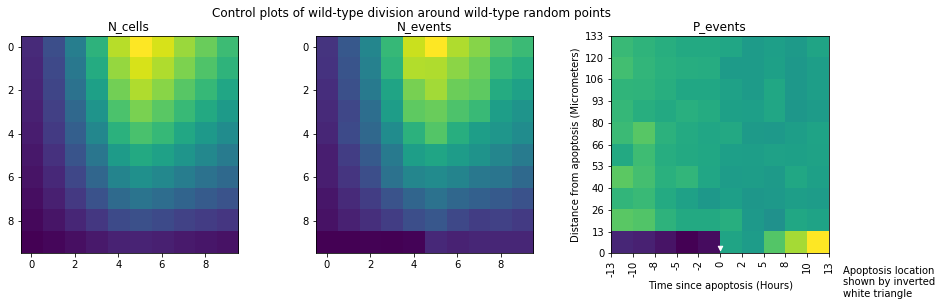

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Control plots of wild-type division around wild-type random points')
fig.set_size_inches(15, 4)
ax1.imshow(N_cells_wt_control_wt_div)
ax1.set_title('N_cells')
ax2.imshow(N_events_wt_control_wt_div)
ax2.set_title('N_events')
ax3.imshow(P_events_wt_control_wt_div)
ax3.set_title('P_events')
plot_labels(SI = True)

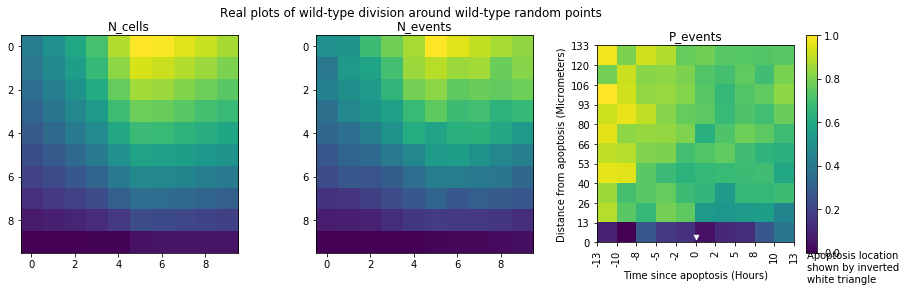

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Real plots of wild-type division around wild-type random points')
fig.set_size_inches(15, 4)
ax1.imshow(N_cells_scr_apop_wt_div)
ax1.set_title('N_cells')
ax2.imshow(N_events_scr_apop_wt_div)
ax2.set_title('N_events')
ax3.imshow(P_events_scr_apop_wt_div)
ax3.set_title('P_events')
plot_labels(SI = True)

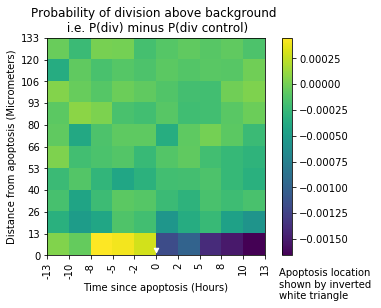

In [171]:
P_events_above_background = P_events_scr_apop_wt_div - P_events_wt_control_wt_div
delta_P = P_events_above_background
plt.imshow(delta_P[:,:])
plt.colorbar()
#plt.clim(0,0.0003)
#plt.clim(-0.0020, 0)
plot_labels(SI=True)
plt.title('Probability of division above background \n i.e. P(div) minus P(div control)')
plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/P(div) above background.pdf', bbox_inches = 'tight')

now need to establish that the probability of division above background is greater than the coeff var of P_events and of the control

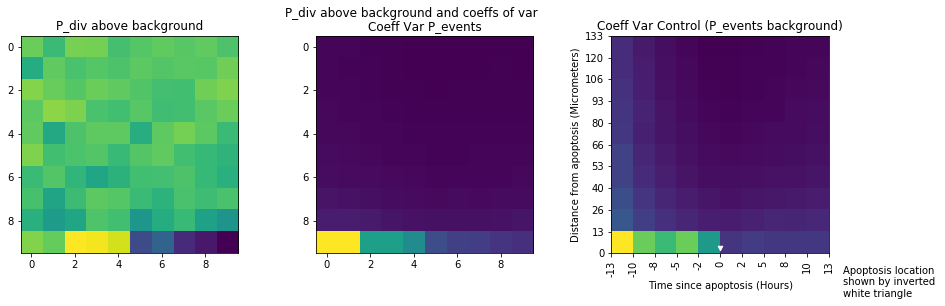

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('P_div above background and coeffs of var')
fig.set_size_inches(15, 4)
ax1.imshow(delta_P)
ax1.set_title('P_div above background')
ax2.imshow(scr_apop_wt_div_CV)
ax2.set_title('Coeff Var P_events')
ax3.imshow(wt_control_wt_div_CV)
ax3.set_title('Coeff Var Control (P_events background)')
plot_labels(SI = True)

Text(0.5, 1.0, 'Coeff var scr_apop_wt_div Prob')

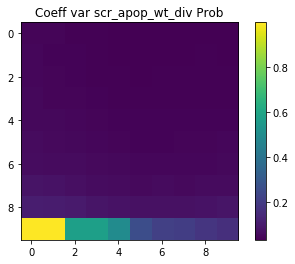

In [112]:
plt.imshow(scr_apop_wt_div_CV)
plt.colorbar()
plt.title('Coeff var scr_apop_wt_div Prob')

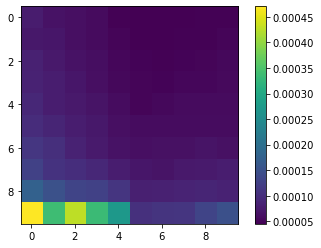

In [111]:
plt.imshow(P_events_scr_apop_wt_div*scr_apop_wt_div_CV)
plt.colorbar()

# Correct method for seeing if P(div) is above background levels

First establish if the P(div) or P(div_control) is larger then do the following

[[0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]]


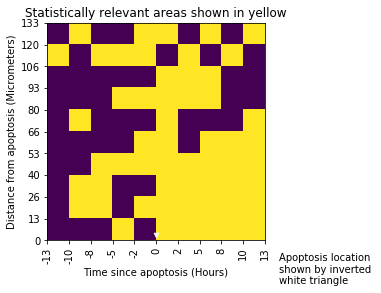

In [170]:
larger_than_array = np.zeros((10,10))
sig_dif_array = np.zeros((10,10))
for i, row in enumerate(P_events_scr_apop_wt_div):
    for j, element in enumerate(row):
        P_div = P_events_scr_apop_wt_div[i,j]
        P_div_control = P_events_wt_control_wt_div[i,j]
        if P_div > P_div_control:
            larger_than_array[i,j] = 1
            measure1 = P_div*(1-scr_apop_wt_div_CV[i,j])
            measure2 = P_div_control*(1+wt_control_wt_div_CV[i,j])
            if measure1 > measure2:
                #print(i,j, 'sig dif')
                sig_dif_array[i,j] = 1
            else:
                #print(i,j, 'NOT sig dif')
                sig_dif_array[i,j] = 0
        else:
            larger_than_array[i,j] = 0
            measure1 = P_div_control*(1-wt_control_wt_div_CV[i,j])
            measure2 = P_div*(1+scr_apop_wt_div_CV[i,j])
            if measure1 > measure2:
                #print(i,j, 'sig dif')
                sig_dif_array[i,j] = 1
            else:
                #print(i,j, 'NOT sig dif')
                sig_dif_array[i,j] = 0
print(larger_than_array)
plt.title('Statistically relevant areas shown in yellow')
plt.imshow(sig_dif_array)
plot_labels(SI = True)
#plt.colorbar()
plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coeff_variation/Statistical relevance of P(div).pdf', bbox_inches = 'tight')

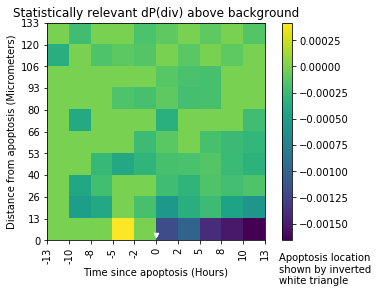

In [180]:
plt.imshow(sig_dif_array*delta_P)
plt.title('Statistically relevant dP(div) above background')
plt.colorbar()
plot_labels(SI=True)

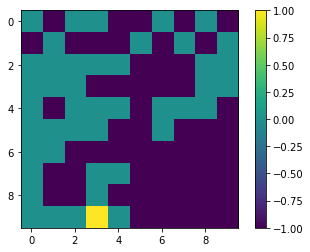

In [179]:
plt.imshow(np.sign(sig_dif_array*delta_P))
plt.colorbar()